In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
from pyod.models.knn import KNN
from pyod.utils.data import generate_data, get_outliers_inliers

In [3]:
# generating a random dataset with two features
X_train, y_train = generate_data(n_train = 300, train_only = True,
                                                   n_features = 2)
 
# Setting the percentage of outliers
outlier_fraction = 0.1
 
# Storing the outliers and inliners in different numpy arrays
X_outliers, X_inliers = get_outliers_inliers(X_train, y_train)
n_inliers = len(X_inliers)
n_outliers = len(X_outliers)
 
# Separating the two features
f1 = X_train[:, [0]].reshape(-1, 1)
f2 = X_train[:, [1]].reshape(-1, 1)

Text(0, 0.5, 'Feature 2')

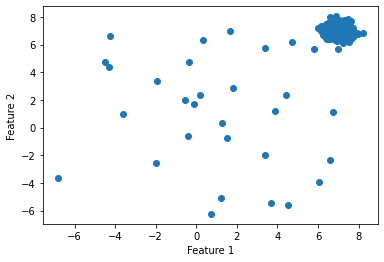

In [4]:
# Visualising the dataset
# create a meshgrid
xx, yy = np.meshgrid(np.linspace(-10, 10, 200),
                     np.linspace(-10, 10, 200))
 
# scatter plot
plt.scatter(f1, f2)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

In [5]:
# Training the classifier
clf = KNN(contamination = outlier_fraction)
clf.fit(X_train, y_train)
 
# You can print this to see all the prediction scores
scores_pred = clf.decision_function(X_train)*-1
 
y_pred = clf.predict(X_train)
n_errors = (y_pred != y_train).sum()
# Counting the number of errors
 
print('The number of prediction errors are ' + str(n_errors))

The number of prediction errors are 0


/opt/anaconda3/envs/Project/lib/python3.8/site-packages/pyod/models/base.py:348: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


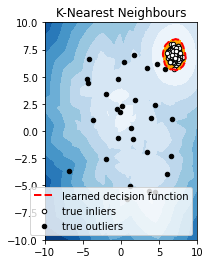

In [6]:
# threshold value to consider a
# datapoint inlier or outlier
threshold = stats.scoreatpercentile(scores_pred, 100 * outlier_fraction)
 
# decision function calculates the raw
# anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
 
# fill blue colormap from minimum anomaly
# score to threshold value
subplot = plt.subplot(1, 2, 1)
subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(),
                  threshold, 10), cmap = plt.cm.Blues_r)
 
# draw red contour line where anomaly
# score is equal to threshold
a = subplot.contour(xx, yy, Z, levels =[threshold],
                     linewidths = 2, colors ='red')
 
# fill orange contour lines where range of anomaly
# score is from threshold to maximum anomaly score
subplot.contourf(xx, yy, Z, levels =[threshold, Z.max()], colors ='orange')
 
# scatter plot of inliers with white dots
b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1],
                                    c ='white', s = 20, edgecolor ='k')
 
# scatter plot of outliers with black dots
c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1],
                                    c ='black', s = 20, edgecolor ='k')
subplot.axis('tight')
 
subplot.legend(
    [a.collections[0], b, c],
    ['learned decision function', 'true inliers', 'true outliers'],
    prop = matplotlib.font_manager.FontProperties(size = 10),
    loc ='lower right')
 
subplot.set_title('K-Nearest Neighbours')
subplot.set_xlim((-10, 10))
subplot.set_ylim((-10, 10))
plt.show()


## Elliptic Envelope


In [7]:
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=300, n_features=2,
                  centers=1, shuffle=True, random_state=1)

<AxesSubplot:>

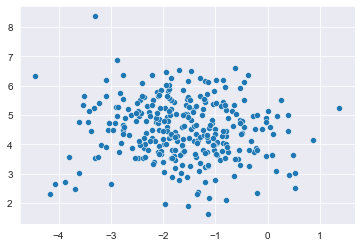

In [8]:
import seaborn as sns
sns.set_style("darkgrid")
sns.scatterplot(x=X[:,0], y=X[:,1])

/opt/anaconda3/envs/Project/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/Project/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

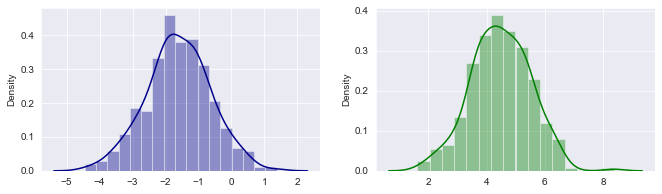

In [9]:
#Checking normality of data. The method works with Gaussian distributed data.
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,3))
sns.distplot(X[:,0], ax=ax[0], color="darkblue")
sns.distplot(X[:,1], ax=ax[1], color='green')

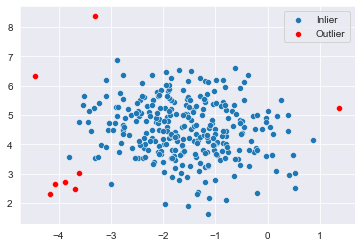

In [12]:
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.covariance import EllipticEnvelope

elpenv = EllipticEnvelope(contamination=0.025, 
                          random_state=1)

# Returns 1 of inliers, -1 for outliers
pred = elpenv.fit_predict(X)

# Extract outliers
outlier_index = np.where(pred==-1)
outlier_values = X[outlier_index]


sns.scatterplot(x=X[:,0], y=X[:,1])
sns.scatterplot(x=outlier_values[:,0], 
                y=outlier_values[:,1], color='r')
plt.legend(['Inlier','Outlier'])

In [13]:
outlier_index

(array([ 17,  87,  97, 128, 179, 207, 214, 263]),)

In [14]:
# Extract inliers
inlier_index = np.where(pred==1)
inlier_values = X[inlier_index]

import pandas as pd
df = pd.DataFrame(inlier_values, columns=['x1', 'x2'])
df.head()

,x1,x2
0,-2.681446,5.201018
1,-0.975559,4.053080
2,-2.879304,6.855859
3,-1.615891,4.180176
4,-1.461260,4.525499


## IQR-based detection

In [15]:
import numpy as np
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=300, n_features=2,
                  centers=1, shuffle=True, random_state=1)

# This function returns the outlier indices of a feature
# Input is one feature
def outlier_indices(x):
    Q1, Q3 = np.percentile(x, [25, 75])
    IQR = Q3-Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    outlier_index = np.where((x < lower_bound) | (x > upper_bound))
    return outlier_index

print("Outlier Indices of x1: ", outlier_indices(X[:,0])[0])
print("\nOutlier Values of x1: \n", X[outlier_indices(X[:,0])])
print("\n")
print("Outlier Indices of x2: ", outlier_indices(X[:,1])[0])
print("\nOutlier Values of x2: \n", X[outlier_indices(X[:,1])])

Outlier Indices of x1:  [ 17  87 128 241 263]

Outlier Values of x1: 
 [[-4.16600056  2.29232595]
 [-4.45264491  6.34401868]
 [-4.07306291  2.62892349]
 [ 0.8687658   4.15785509]
 [ 1.37129721  5.23107449]]


Outlier Indices of x2:  [207 211]

Outlier Values of x2: 
 [[-3.2970095   8.36509257]
 [-1.14448629  1.6239554 ]]


In [16]:
import numpy as np
index_union = np.union1d(outlier_indices(X[:,0])[0], 
                         outlier_indices(X[:,1])[0])
index_union

array([ 17,  87, 128, 207, 211, 241, 263])

Text(0.5, 1.0, 'IQR-based Detection')

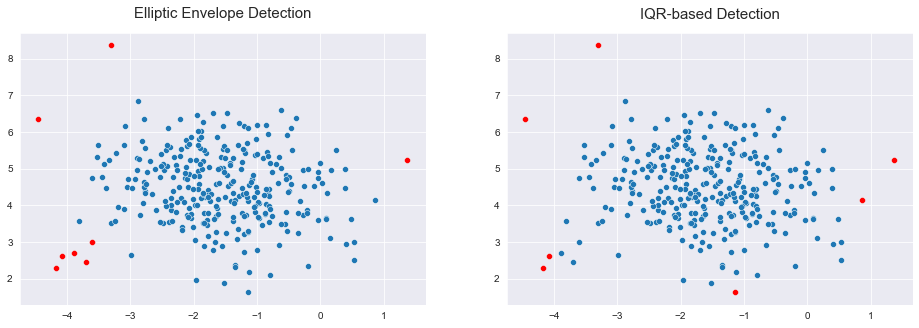

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

sns.scatterplot(x=X[:,0], y=X[:,1], ax=ax[0])
sns.scatterplot(x=outlier_values[:,0], ax=ax[0],
                y=outlier_values[:,1], color='r')

sns.scatterplot(x=X[:,0], y=X[:,1], ax=ax[1])
sns.scatterplot(x=X[index_union][:,0], y=X[index_union][:,1], ax=ax[1],
                color='r')

ax[0].set_title("Elliptic Envelope Detection", fontsize=15, pad=15)
ax[1].set_title("IQR-based Detection", fontsize=15, pad=15)

Text(0.5, 1.0, 'Data without outliers')

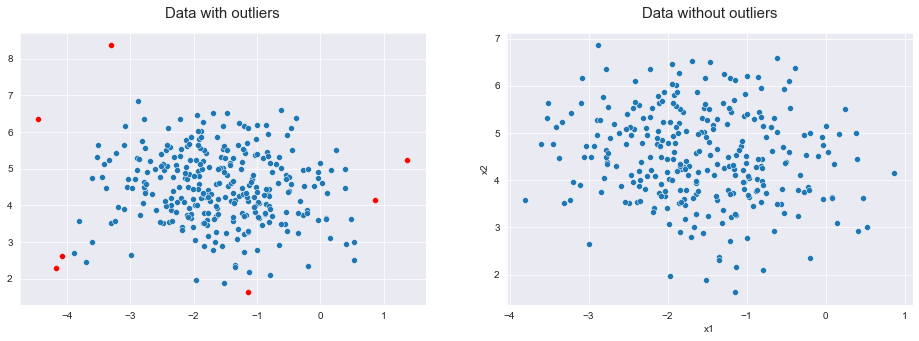

In [18]:
import pandas as pd

df = pd.DataFrame(inlier_values, columns=['x1', 'x2'])
cleaned_df = df.drop(labels=index_union, axis=0, inplace=False)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

sns.scatterplot(x=X[:,0], y=X[:,1], ax=ax[0])
sns.scatterplot(x=X[index_union][:,0], y=X[index_union][:,1], ax=ax[0],
                color='r')

sns.scatterplot(x=cleaned_df['x1'], y=cleaned_df['x2'], ax=ax[1])

ax[0].set_title("Data with outliers", fontsize=15, pad=15)
ax[1].set_title("Data without outliers", fontsize=15, pad=15)

Text(0.5, 1.0, 'Boxplot of x2 without outliers')

<Figure size 432x288 with 0 Axes>

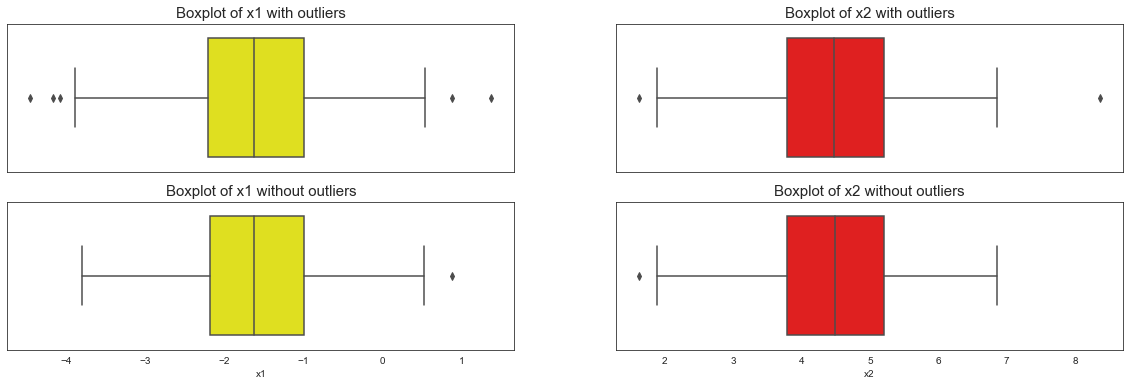

In [19]:
sns.set_style("white")
import matplotlib.pyplot as plt
plt.tight_layout(pad=10)

fig, ax = plt.subplots(nrows=2, ncols=2,
                       figsize=(20,6), sharex='col')
sns.boxplot(x=X[:,0], ax=ax[0,0], color='yellow')
sns.boxplot(x=X[:,1], ax=ax[0,1], color='red')
sns.boxplot(x=cleaned_df['x1'], ax=ax[1,0], color='yellow')
sns.boxplot(x=cleaned_df['x2'], ax=ax[1,1], color='red')

ax[0,0].set_title("Boxplot of x1 with outliers", fontsize=15)
ax[0,1].set_title("Boxplot of x2 with outliers", fontsize=15)
ax[1,0].set_title("Boxplot of x1 without outliers", fontsize=15)
ax[1,1].set_title("Boxplot of x2 without outliers", fontsize=15)